<a href="https://colab.research.google.com/github/tomasb199/DM---Weather/blob/master/OZNAL_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [29]:
%tensorflow_version 2.x
!pip install geopandas
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import seaborn
import sklearn
import statistics
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
#
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

import librosa
import datetime
import os
import math

import descartes
import geopandas

import PIL.Image
from io import BytesIO
from IPython.display import Image, display

from google.colab import drive
drive.mount('/content/drive/')

# load dataset from google drive
weather_datapath = "/content/drive/My Drive/irish_weather_dataset/hourly_irish_weather.csv"
weather_data = pd.read_csv(weather_datapath, index_col=0)

# index by date
weather_data['date'] = pd.to_datetime(weather_data['date'], infer_datetime_format=True)
weather_data.set_index('date', inplace=True)

# display info for each station
weather_stations = {}
# cez vsetky stanice
for i,station in enumerate(weather_data['station'].unique()):
  weather_station = weather_data[weather_data.station == station]
  pd.DataFrame(weather_station)
  weather_stations[station] = weather_station

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## NN - Stateful=false
#### Prediction of future temperature

In [8]:
###LSTM RNN###
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

# fill missing values with median
dataset = dataset.fillna(dataset.interpolate(method='linear', limit_direction='forward', axis=0))

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

#Get first 50000 hour
dataset = dataset[:50000]

#Add MAs attributes
dataset['MA_12'] = dataset.iloc[:,1].rolling(window=12).mean()
dataset['MA_24'] = dataset.iloc[:,1].rolling(window=24).mean()

#Cut logs without MA
dataset = dataset[24:]

#############################################USED ATTRIBUTES PARAMETERS#######################################
# a. vyber atributy s najvyssimi korelaciami
dataset = dataset.filter(['temp', 'day', 'MA_12', 'MA_24', 'hour', 'vappr', 'rhum'])

# b. Only temp attribute
#dataset = dataset.filter(['temp'])
#############################################TEST PARAMETERS#######################################
sequence_length_test = [24, 48, 72, 168]
prediction_length_test = [1, 2, 3, 12]
#########################################################################################################
for sequence_length in sequence_length_test:
  for prediction_length in prediction_length_test:
    temp_shifted = dataset[['temp']]#.shift(-prediction_length)
    x_data = dataset.values[0:-prediction_length]
    y_data = temp_shifted.values[:-prediction_length]

    # train and test set 80:20
    training_data_len = math.ceil(len(x_data) * .8)
    x_train = x_data[0:training_data_len]
    x_test = x_data[training_data_len:]
    y_train = y_data[0:training_data_len]
    y_test = y_data[training_data_len:]

    #Scale the data
    scaler_x = MinMaxScaler(feature_range=(0,1))
    x_train_scaled = scaler_x.fit_transform(x_train)
    x_test_scaled = scaler_x.transform(x_test)
    scaler_y = MinMaxScaler(feature_range=(0,1))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    ###########################################TRAIN DATASET###############################################################
    # size of new dataset
    _size = training_data_len - sequence_length - prediction_length

    x_train_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
    y_train_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

    for i in range(_size):
      x_train_window[i] = x_train_scaled[i:i+sequence_length]
      y_train_window[i] = y_train_scaled[i+sequence_length:i+sequence_length+prediction_length]

    ##########################################VALIDATION DATASET############################################################
    _size = len(x_test) - sequence_length - prediction_length

    x_valid_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
    y_valid_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

    for i in range(_size):
      x_valid_window[i] = x_test_scaled[i:i+sequence_length]
      y_valid_window[i] = y_test_scaled[i+sequence_length:i+sequence_length+prediction_length]

    #########################################################################################################################

    #Build the LSTM model
    def create_model():
      model = keras.Sequential()
      model.add(keras.layers.LSTM(units=75, stateful=False, return_sequences=True, input_shape=(x_train_window.shape[1], x_train_window.shape[2],)))
      model.add(keras.layers.Dropout(0.2))
      model.add(keras.layers.LSTM(units=75, stateful=False, return_sequences=False))
      model.add(keras.layers.Dropout(0.2))
      model.add(keras.layers.Dense(prediction_length))
      model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
      #model.summary()
      return model

    model = create_model()
    keras.backend.set_epsilon(1) # potrebne pre metriku mape

    #Early stopping
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    #Train the model
    model.fit(x_train_window, y_train_window, batch_size=32, epochs=30, callbacks=[callback], validation_data=(x_valid_window, y_valid_window), verbose=0)

    #############################################TESTING DATASET#########################################
    _size = math.floor((len(x_test) - sequence_length) / prediction_length)

    x_test_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
    y_test_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

    ii = 0
    for i in range(_size):
      x_test_window[i] = x_test_scaled[ii:ii+sequence_length]
      y_test_window[i] = y_test_scaled[ii+sequence_length:ii+sequence_length+prediction_length]
      ii += prediction_length

    #####################################################################################################

    # evaluate the model
    model.evaluate(x_test_window, y_test_window)

    # get the model predicted temperature
    predictions = model.predict(x_test_window)
    predictions = scaler_y.inverse_transform(predictions)
    predictions = predictions.flatten()

    # Calculate unscaled MSE, MAE
    b = -(len(x_test)-(_size*prediction_length+sequence_length))
    MSE = mean_squared_error(y_test[sequence_length:b if b !=0 else None], predictions)
    MAE = mean_absolute_error(y_test[sequence_length:b if b !=0 else None], predictions)
    print('sequence_length: ', sequence_length)
    print('prediction_length: ', prediction_length)
    print(f'{np.round(np.sqrt(MSE), 3)}\t{np.round(MSE, 3)}\t{np.round(MAE, 3)}')

312/312 [==============================] - 1s 5ms/step - loss: 4.1404e-04 - mse: 4.1404e-04 - mae: 0.0145 - mape: 1.4504
sequence_length:  24
prediction_length:  1
0.682	0.465	0.486
156/156 [==============================] - 1s 5ms/step - loss: 6.7808e-04 - mse: 6.7808e-04 - mae: 0.0188 - mape: 1.8811
sequence_length:  24
prediction_length:  2
0.872	0.761	0.63
104/104 [==============================] - 0s 5ms/step - loss: 9.8422e-04 - mse: 9.8422e-04 - mae: 0.0228 - mape: 2.2821
sequence_length:  24
prediction_length:  3
1.051	1.105	0.765
26/26 [==============================] - 0s 4ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0375 - mape: 3.7479
sequence_length:  24
prediction_length:  12
1.673	2.798	1.255
311/311 [==============================] - 2s 6ms/step - loss: 3.9962e-04 - mse: 3.9962e-04 - mae: 0.0143 - mape: 1.4349
sequence_length:  48
prediction_length:  1
0.67	0.449	0.481
156/156 [==============================] - 1s 5ms/step - loss: 6.5745e-04 - mse: 6.5745e-04 - mae: 0.

## Linear Regression
#### Prediction of future temperature

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

dataset = weather_stations['Dublin_Airport']
dataset = dataset[:50000].filter(['temp'])

dataset = dataset.fillna(dataset.interpolate(method='linear', limit_direction='forward', axis=0))
print(dataset.head(3))

#############################################PREDICTION PARAMETERS#######################################
# na zaklade kolkych hodin dozadu sa bude predpovedat n hodin dopredu
sequence_length = 24
prediction_length = 1
#########################################################################################################
sequence_length_test = [24, 48, 72, 168]
prediction_length_test = [1, 2, 3, 12]
for sequence_length in sequence_length_test:
  for prediction_length in prediction_length_test:
    temp_shifted = dataset[['temp']]
    x_data = dataset.values[0:-prediction_length]
    y_data = temp_shifted.values[:-prediction_length]

    # train and test set 80:20
    training_data_len = math.ceil(len(x_data) * .8)
    x_train = x_data[0:training_data_len]
    x_test = x_data[training_data_len:]
    y_train = y_data[0:training_data_len]
    y_test = y_data[training_data_len:]

    #Scale the data
    scaler_x = MinMaxScaler(feature_range=(0,1))
    x_train_scaled = scaler_x.fit_transform(x_train)
    x_test_scaled = scaler_x.transform(x_test)
    scaler_y = MinMaxScaler(feature_range=(0,1))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    ###########################################TRAIN DATASET###############################################################
    # size of new dataset
    _size = training_data_len - sequence_length - prediction_length

    x_train_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
    y_train_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

    for i in range(_size):
      x_train_window[i] = x_train_scaled[i:i+sequence_length]
      y_train_window[i] = y_train_scaled[i+sequence_length:i+sequence_length+prediction_length]

    ##########################################VALIDATION DATASET############################################################
    _size = math.floor((len(x_test) - sequence_length) / prediction_length)

    x_valid_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
    y_valid_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

    ii = 0
    for i in range(_size):
      x_valid_window[i] = x_test_scaled[ii:ii+sequence_length]
      y_valid_window[i] = y_test_scaled[ii+sequence_length:ii+sequence_length+prediction_length]
      ii += prediction_length

    #########################################################################################################################

    # reshape the data for Random forest
    x_train_window = x_train_window.reshape(x_train_window.shape[0], x_train_window.shape[1])
    y_train_window = y_train_window.reshape(y_train_window.shape[0], y_train_window.shape[1])

    x_valid_window = x_valid_window.reshape(x_valid_window.shape[0], x_valid_window.shape[1])
    y_valid_window = y_valid_window.reshape(y_valid_window.shape[0], y_valid_window.shape[1])
    
    ##################################################LINEAR REGRESSION#######################################################
    # Train and predict
    model_lr = LinearRegression()
    model_lr.fit(x_train_window, y_train_window);
    predictions_lr = model_lr.predict(x_valid_window)

    predictions_lr = scaler_y.inverse_transform(predictions_lr)
    y_valid_unscaled = scaler_y.inverse_transform(y_valid_window)
    predictions_lr = predictions_lr.flatten()
    y_valid_unscaled = y_valid_unscaled.flatten()

    RMSE = np.round(np.sqrt(mean_squared_error(y_valid_unscaled, predictions_lr)), 3)
    MSE = np.round(mean_squared_error(y_valid_unscaled, predictions_lr), 3)
    MAE = np.round(mean_absolute_error(y_valid_unscaled, predictions_lr), 3)
    print('sequence_length: ', sequence_length)
    print('prediction_length: ', prediction_length)
    print(f'{RMSE:.3f}\t{MSE:.3f}\t{MAE:.3f}')

                     temp
date                     
1989-01-01 00:00:00   6.8
1989-01-01 01:00:00   7.9
1989-01-01 02:00:00   7.9
sequence_length:  24
prediction_length:  1
0.680	0.462	0.484
sequence_length:  24
prediction_length:  2
0.859	0.737	0.614
sequence_length:  24
prediction_length:  3
1.018	1.037	0.724
sequence_length:  24
prediction_length:  12
1.998	3.991	1.497
sequence_length:  48
prediction_length:  1
0.667	0.446	0.477
sequence_length:  48
prediction_length:  2
0.838	0.702	0.603
sequence_length:  48
prediction_length:  3
0.989	0.979	0.709
sequence_length:  48
prediction_length:  12
1.880	3.534	1.419
sequence_length:  72
prediction_length:  1
0.664	0.440	0.474
sequence_length:  72
prediction_length:  2
0.830	0.689	0.598
sequence_length:  72
prediction_length:  3
0.975	0.951	0.702
sequence_length:  72
prediction_length:  12
1.842	3.395	1.398
sequence_length:  168
prediction_length:  1
0.658	0.432	0.471
sequence_length:  168
prediction_length:  2
0.818	0.669	0.591
sequence_le

##Random Forest
#### Prediction of future temperature

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

dataset = weather_stations['Dublin_Airport']
dataset = dataset[:50000].filter(['temp'])

dataset = dataset.fillna(dataset.interpolate(method='linear', limit_direction='forward', axis=0))
print(dataset.head(3))

#############################################PREDICTION PARAMETERS#######################################
# na zaklade kolkych hodin dozadu sa bude predpovedat n hodin dopredu
sequence_length = 24
prediction_length = 1
#########################################################################################################
sequence_length_test = [24, 48, 72, 168]
prediction_length_test = [1, 2, 3, 12]
for sequence_length in sequence_length_test:
  for prediction_length in prediction_length_test:
    temp_shifted = dataset[['temp']]
    x_data = dataset.values[0:-prediction_length]
    y_data = temp_shifted.values[:-prediction_length]

    # train and test set 80:20
    training_data_len = math.ceil(len(x_data) * .8)
    x_train = x_data[0:training_data_len]
    x_test = x_data[training_data_len:]
    y_train = y_data[0:training_data_len]
    y_test = y_data[training_data_len:]

    #Scale the data
    scaler_x = MinMaxScaler(feature_range=(0,1))
    x_train_scaled = scaler_x.fit_transform(x_train)
    x_test_scaled = scaler_x.transform(x_test)
    scaler_y = MinMaxScaler(feature_range=(0,1))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    ###########################################TRAIN DATASET###############################################################
    # size of new dataset
    _size = training_data_len - sequence_length - prediction_length

    x_train_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
    y_train_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

    for i in range(_size):
      x_train_window[i] = x_train_scaled[i:i+sequence_length]
      y_train_window[i] = y_train_scaled[i+sequence_length:i+sequence_length+prediction_length]

    ##########################################VALIDATION DATASET############################################################
    _size = math.floor((len(x_test) - sequence_length) / prediction_length)

    x_valid_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
    y_valid_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

    ii = 0
    for i in range(_size):
      x_valid_window[i] = x_test_scaled[ii:ii+sequence_length]
      y_valid_window[i] = y_test_scaled[ii+sequence_length:ii+sequence_length+prediction_length]
      ii += prediction_length

    #########################################################################################################################

    # reshape the data for Random forest
    x_train_window = x_train_window.reshape(x_train_window.shape[0], x_train_window.shape[1])
    y_train_window = y_train_window.reshape(y_train_window.shape[0], y_train_window.shape[1])

    x_valid_window = x_valid_window.reshape(x_valid_window.shape[0], x_valid_window.shape[1])
    y_valid_window = y_valid_window.reshape(y_valid_window.shape[0], y_valid_window.shape[1])
    
    ##################################################LINEAR REGRESSION#######################################################
    y_valid_unscaled = scaler_y.inverse_transform(y_valid_window)
    y_valid_unscaled = y_valid_unscaled.flatten()
    
    # Train and predict
    model_rf = RandomForestRegressor(n_estimators=100)
    model_rf.fit(x_train_window, y_train_window);
    predictions_rf = model_rf.predict(x_valid_window)

    if(prediction_length == 1):
      predictions_rf = predictions_rf.reshape(predictions_rf.shape[0], 1)

    predictions_rf = scaler_y.inverse_transform(predictions_rf)
    predictions_rf = predictions_rf.flatten()

    RMSE = np.round(np.sqrt(mean_squared_error(y_valid_unscaled, predictions_rf)), 3)
    MSE = np.round(mean_squared_error(y_valid_unscaled, predictions_rf), 3)
    MAE = np.round(mean_absolute_error(y_valid_unscaled, predictions_rf), 3)
    print('sequence_length: ', sequence_length)
    print('prediction_length: ', prediction_length)
    print(f'{RMSE:.3f}\t{MSE:.3f}\t{MAE:.3f}')


                     temp
date                     
1989-01-01 00:00:00   6.8
1989-01-01 01:00:00   7.9
1989-01-01 02:00:00   7.9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


sequence_length:  24
prediction_length:  1
0.685	0.469	0.491
sequence_length:  24
prediction_length:  2
0.861	0.741	0.618
sequence_length:  24
prediction_length:  3
1.011	1.023	0.724
sequence_length:  24
prediction_length:  12
1.934	3.742	1.429


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


sequence_length:  48
prediction_length:  1
0.670	0.449	0.481
sequence_length:  48
prediction_length:  2
0.836	0.698	0.600
sequence_length:  48
prediction_length:  3
0.980	0.961	0.703
sequence_length:  48
prediction_length:  12
1.846	3.409	1.393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


sequence_length:  72
prediction_length:  1
0.670	0.448	0.480
sequence_length:  72
prediction_length:  2
0.831	0.691	0.600
sequence_length:  72
prediction_length:  3
0.977	0.955	0.701
sequence_length:  72
prediction_length:  12
1.818	3.304	1.374


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


sequence_length:  168
prediction_length:  1
0.667	0.445	0.479
sequence_length:  168
prediction_length:  2
0.829	0.687	0.597
sequence_length:  168
prediction_length:  3
0.972	0.945	0.699
sequence_length:  168
prediction_length:  12
1.776	3.153	1.349


#Neural network - MLP
#### predicting temperature in another place based on root measure station

In [43]:
from sklearn.model_selection import train_test_split # Using Skicit-learn to split data into training and testing sets
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import residuals_plot


# Root measure station
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour
#############################################PREDICTION PARAMETERS#######################################
MAs = [[1, 'temp'], [0, 'rain']] # 1 - temp, 2 - rain
stations = ['Casement', 'Mullingar']
#########################################################################################################
for MA in MAs:
  for station in stations:
    if(MA[0] == 1):
      dataset['MA_12'] = dataset.iloc[:,MA[0]].rolling(window=12).mean()
      dataset['MA_24'] = dataset.iloc[:,MA[0]].rolling(window=24).mean()
    elif((MA[0] == 0) and ('MA_12' in dataset.columns) and ('MA_24' in dataset.columns)):
      dataset = dataset.drop(columns=['MA_12', 'MA_24'])
    print(dataset.shape)
    # Place where is predict temperature
    dataset2 = weather_stations[station] #['Mullingar']
    dataset2 = dataset2.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)
    #Add predict temp to root DF
    dataset['temp2'] = dataset2[MA[1]]

    # fill NaN with interpolate
    dataset = dataset.fillna(dataset.interpolate(method='linear', limit_direction='forward', axis=0))
    #Verify prepared DF
    features = dataset[50000:100000]
    print(features.head(10))
    # Labels are the values we want to predict
    labels = np.array(features['temp2'])
    #print(labels)
    # Remove the labels from the features
    # axis 1 refers to the columns
    features= features.drop('temp2', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, shuffle=False)
    train_labels = train_labels.reshape(-1,1)
    test_labels = test_labels.reshape(-1,1)

    #Scale the data
    scaler_x = MinMaxScaler(feature_range=(0,1))
    x_train_scaled = scaler_x.fit_transform(train_features)
    x_test_scaled = scaler_x.transform(test_features)
    scaler_y = MinMaxScaler(feature_range=(0,1))
    y_train_scaled = scaler_y.fit_transform(train_labels)
    y_test_scaled = scaler_y.transform(test_labels)

    # define the keras model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=64, input_shape=(train_features.shape[1],), activation = 'sigmoid'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(units=48, activation = 'sigmoid'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    optimizer = keras.optimizers.Nadam(learning_rate=0.01)
    # compile the keras model
    model.compile(loss='mse', optimizer='Nadam', metrics=['mse'])

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # fit the keras model on the dataset
    model.fit(x_train_scaled, y_train_scaled, epochs=20, batch_size=8, verbose=1, validation_split=0.2, callbacks=[callback])

    # make class predictions with the model
    predictions = model.predict(x_test_scaled)
    predictions = scaler_y.inverse_transform(predictions)

    print(f'{round(np.sqrt(mean_squared_error(test_labels, predictions)), 3)}\t{round(mean_squared_error(test_labels, predictions), 3)}\t{round(mean_absolute_error(test_labels, predictions), 3)}')

(254208, 17)
                     rain  temp  vappr  rhum  ...  hour      MA_12      MA_24  temp2
date                                          ...                                   
1994-09-15 08:00:00   0.0   8.5   10.3  93.0  ...     8   9.541667  10.641667    9.0
1994-09-15 09:00:00   0.0   9.3   10.5  89.0  ...     9   9.400000  10.558333    9.2
1994-09-15 10:00:00   0.0   9.9   10.4  86.0  ...    10   9.333333  10.495833    9.6
1994-09-15 11:00:00   0.0  10.5   10.4  82.0  ...    11   9.358333  10.454167   10.0
1994-09-15 12:00:00   0.0  11.1   10.0  75.0  ...    12   9.400000  10.404167   10.8
1994-09-15 13:00:00   0.0  11.5    9.8  72.0  ...    13   9.508333  10.362500   11.2
1994-09-15 14:00:00   0.0  11.7    9.2  67.0  ...    14   9.666667  10.350000   11.6
1994-09-15 15:00:00   0.0  11.4    9.4  70.0  ...    15   9.850000  10.316667   11.8
1994-09-15 16:00:00   0.0  11.2   10.0  75.0  ...    16  10.033333  10.287500    9.6
1994-09-15 17:00:00   0.0  11.0   10.3  79.0  ...   

# Linear regression

#### predicting temperature in another place based on root measure station

In [36]:
from sklearn.model_selection import train_test_split # Using Skicit-learn to split data into training and testing sets
from sklearn.linear_model import LinearRegression # Import the model we are using
from sklearn.preprocessing import PolynomialFeatures 


# Root measure station
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

#############################################PREDICTION PARAMETERS#######################################
MAs = [[1, 'temp'], [0, 'rain']] # 1 - temp, 2 - rain
stations = ['Casement', 'Mullingar']
#########################################################################################################
for MA in MAs:
  for station in stations:
    if(MA[0] == 1):
      dataset['MA_12'] = dataset.iloc[:,1].rolling(window=12).mean()
      dataset['MA_24'] = dataset.iloc[:,1].rolling(window=24).mean()
    elif((MA[0] == 0) and ('MA_12' in dataset.columns) and ('MA_24' in dataset.columns)):
      dataset = dataset.drop(columns=['MA_12', 'MA_24'])
    # Place where is predict temperature
    dataset2 = weather_stations[station] #['Mullingar']
    dataset2 = dataset2.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)
    #Add predict temp to root DF
    dataset['temp2'] = dataset2[MA[1]]

    # fill NaN with interpolate
    dataset = dataset.fillna(dataset.interpolate(method='linear', limit_direction='forward', axis=0))
    #Verify prepared DF
    features = dataset[50000:100000]
    print(features.head(10))

    # Labels are the values we want to predict
    labels = np.array(features['temp2'])
    #print(labels)
    # Remove the labels from the features
    # axis 1 refers to the columns
    features= features.drop('temp2', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, shuffle=False)

    #Linear Regression
    poly = PolynomialFeatures(degree = 3) 
    X_poly = poly.fit_transform(train_features)
    Y_poly = poly.fit_transform(test_features)
      
    poly.fit(X_poly, train_labels) 
    lin2 = LinearRegression() 
    lin2.fit(X_poly, train_labels)
    predictions = lin2.predict(Y_poly)

    print(f'{i}\t{round(np.sqrt(mean_squared_error(test_labels, predictions)), 3)}\t{round(mean_squared_error(test_labels, predictions), 3)}\t{round(mean_absolute_error(test_labels, predictions), 3)}')

                     rain  temp  vappr  rhum  ...  hour      MA_12      MA_24  temp2
date                                          ...                                   
1994-09-15 08:00:00   0.0   8.5   10.3  93.0  ...     8   9.541667  10.641667    9.0
1994-09-15 09:00:00   0.0   9.3   10.5  89.0  ...     9   9.400000  10.558333    9.2
1994-09-15 10:00:00   0.0   9.9   10.4  86.0  ...    10   9.333333  10.495833    9.6
1994-09-15 11:00:00   0.0  10.5   10.4  82.0  ...    11   9.358333  10.454167   10.0
1994-09-15 12:00:00   0.0  11.1   10.0  75.0  ...    12   9.400000  10.404167   10.8
1994-09-15 13:00:00   0.0  11.5    9.8  72.0  ...    13   9.508333  10.362500   11.2
1994-09-15 14:00:00   0.0  11.7    9.2  67.0  ...    14   9.666667  10.350000   11.6
1994-09-15 15:00:00   0.0  11.4    9.4  70.0  ...    15   9.850000  10.316667   11.8
1994-09-15 16:00:00   0.0  11.2   10.0  75.0  ...    16  10.033333  10.287500    9.6
1994-09-15 17:00:00   0.0  11.0   10.3  79.0  ...    17  10.23333

# Random Forest
#### predicting temperature in another place based on root measure station

                     rain  temp  vappr  rhum  ...  hour      MA_12      MA_24  temp2
date                                          ...                                   
1994-09-15 08:00:00   0.0   8.5   10.3  93.0  ...     8   9.541667  10.641667    9.0
1994-09-15 09:00:00   0.0   9.3   10.5  89.0  ...     9   9.400000  10.558333    9.2
1994-09-15 10:00:00   0.0   9.9   10.4  86.0  ...    10   9.333333  10.495833    9.6
1994-09-15 11:00:00   0.0  10.5   10.4  82.0  ...    11   9.358333  10.454167   10.0
1994-09-15 12:00:00   0.0  11.1   10.0  75.0  ...    12   9.400000  10.404167   10.8
1994-09-15 13:00:00   0.0  11.5    9.8  72.0  ...    13   9.508333  10.362500   11.2
1994-09-15 14:00:00   0.0  11.7    9.2  67.0  ...    14   9.666667  10.350000   11.6
1994-09-15 15:00:00   0.0  11.4    9.4  70.0  ...    15   9.850000  10.316667   11.8
1994-09-15 16:00:00   0.0  11.2   10.0  75.0  ...    16  10.033333  10.287500    9.6
1994-09-15 17:00:00   0.0  11.0   10.3  79.0  ...    17  10.23333

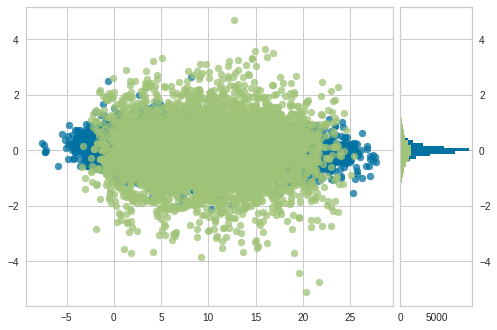

                     rain  temp  vappr  rhum  ...  hour      MA_12      MA_24  temp2
date                                          ...                                   
1994-09-15 08:00:00   0.0   8.5   10.3  93.0  ...     8   9.541667  10.641667    7.9
1994-09-15 09:00:00   0.0   9.3   10.5  89.0  ...     9   9.400000  10.558333    8.9
1994-09-15 10:00:00   0.0   9.9   10.4  86.0  ...    10   9.333333  10.495833    9.2
1994-09-15 11:00:00   0.0  10.5   10.4  82.0  ...    11   9.358333  10.454167   10.4
1994-09-15 12:00:00   0.0  11.1   10.0  75.0  ...    12   9.400000  10.404167   11.2
1994-09-15 13:00:00   0.0  11.5    9.8  72.0  ...    13   9.508333  10.362500   11.4
1994-09-15 14:00:00   0.0  11.7    9.2  67.0  ...    14   9.666667  10.350000   11.5
1994-09-15 15:00:00   0.0  11.4    9.4  70.0  ...    15   9.850000  10.316667   11.9
1994-09-15 16:00:00   0.0  11.2   10.0  75.0  ...    16  10.033333  10.287500   11.6
1994-09-15 17:00:00   0.0  11.0   10.3  79.0  ...    17  10.23333

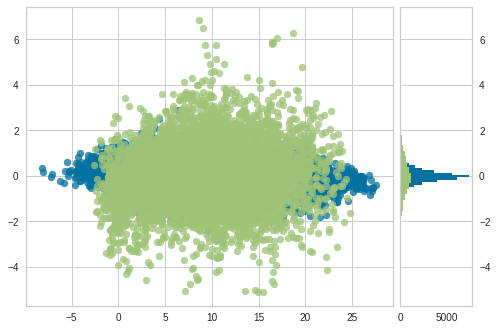

                     rain  temp  vappr  rhum  ...  clamt  day  hour  temp2
date                                          ...                         
1994-09-15 08:00:00   0.0   8.5   10.3  93.0  ...    7.0  258     8    0.0
1994-09-15 09:00:00   0.0   9.3   10.5  89.0  ...    7.0  258     9    0.0
1994-09-15 10:00:00   0.0   9.9   10.4  86.0  ...    8.0  258    10    0.0
1994-09-15 11:00:00   0.0  10.5   10.4  82.0  ...    8.0  258    11    0.0
1994-09-15 12:00:00   0.0  11.1   10.0  75.0  ...    8.0  258    12    0.0
1994-09-15 13:00:00   0.0  11.5    9.8  72.0  ...    7.0  258    13    0.0
1994-09-15 14:00:00   0.0  11.7    9.2  67.0  ...    8.0  258    14    0.0
1994-09-15 15:00:00   0.0  11.4    9.4  70.0  ...    8.0  258    15    0.0
1994-09-15 16:00:00   0.0  11.2   10.0  75.0  ...    8.0  258    16    0.4
1994-09-15 17:00:00   0.0  11.0   10.3  79.0  ...    7.0  258    17    0.0

[10 rows x 16 columns]
0.344	0.119	0.085


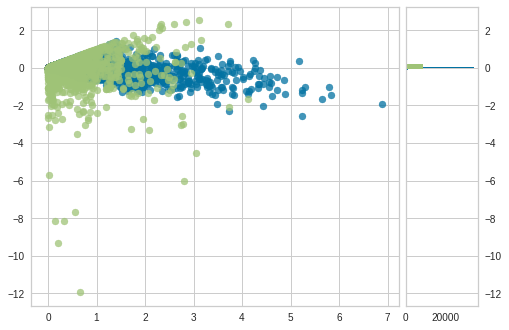

                     rain  temp  vappr  rhum  ...  clamt  day  hour  temp2
date                                          ...                         
1994-09-15 08:00:00   0.0   8.5   10.3  93.0  ...    7.0  258     8    0.4
1994-09-15 09:00:00   0.0   9.3   10.5  89.0  ...    7.0  258     9    0.0
1994-09-15 10:00:00   0.0   9.9   10.4  86.0  ...    8.0  258    10    0.0
1994-09-15 11:00:00   0.0  10.5   10.4  82.0  ...    8.0  258    11    0.0
1994-09-15 12:00:00   0.0  11.1   10.0  75.0  ...    8.0  258    12    0.0
1994-09-15 13:00:00   0.0  11.5    9.8  72.0  ...    7.0  258    13    0.0
1994-09-15 14:00:00   0.0  11.7    9.2  67.0  ...    8.0  258    14    0.0
1994-09-15 15:00:00   0.0  11.4    9.4  70.0  ...    8.0  258    15    0.0
1994-09-15 16:00:00   0.0  11.2   10.0  75.0  ...    8.0  258    16    0.0
1994-09-15 17:00:00   0.0  11.0   10.3  79.0  ...    7.0  258    17    0.0

[10 rows x 16 columns]
0.41	0.168	0.155


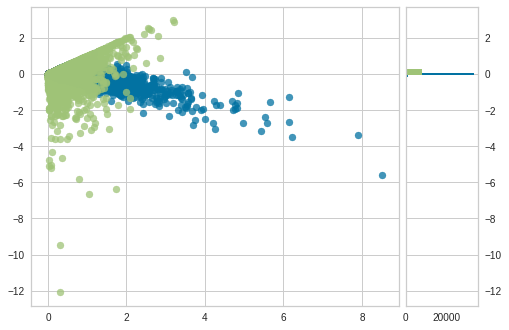

In [41]:
from sklearn.model_selection import train_test_split # Using Skicit-learn to split data into training and testing sets
from sklearn.ensemble import RandomForestRegressor # Import the model we are using
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

# Root measure station
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

#############################################PREDICTION PARAMETERS#######################################
MAs = [[1, 'temp'], [0, 'rain']] # 1 - temp, 2 - rain
stations = ['Casement', 'Mullingar']
#########################################################################################################
for MA in MAs:
  for station in stations:
    if(MA[0] == 1):
      dataset['MA_12'] = dataset.iloc[:,1].rolling(window=12).mean()
      dataset['MA_24'] = dataset.iloc[:,1].rolling(window=24).mean()
    elif((MA[0] == 0) and ('MA_12' in dataset.columns) and ('MA_24' in dataset.columns)):
      dataset = dataset.drop(columns=['MA_12', 'MA_24'])
    # Place where is predict temperature
    dataset2 = weather_stations[station] #['Mullingar']
    dataset2 = dataset2.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)
    #Add predict temp to root DF
    dataset['temp2'] = dataset2[MA[1]]

    # fill NaN with interpolate
    dataset = dataset.fillna(dataset.interpolate(method='linear', limit_direction='forward', axis=0))
    #Verify prepared DF
    features = dataset[50000:100000]
    print(features.head(10))

    # Labels are the values we want to predict
    labels = np.array(features['temp2'])
    #print(labels)
    # Remove the labels from the features
    # axis 1 refers to the columns
    features= features.drop('temp2', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, shuffle=False)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 100)
    # Train the model on training data
    rf.fit(train_features, train_labels);

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    print(f'{round(np.sqrt(mean_squared_error(test_labels, predictions)), 3)}\t{round(mean_squared_error(test_labels, predictions), 3)}\t{round(mean_absolute_error(test_labels, predictions), 3)}')
    
    #Residual plot
    visualizer = ResidualsPlot(rf)

    visualizer.fit(train_features, train_labels)  # Fit the training data to the visualizer
    visualizer.score(test_features, test_labels)  # Evaluate the model on the test data
    plt.show()                             # Finalize and render the figure